In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam, SGD
from tqdm import tqdm, trange

In [3]:
train_df = pd.read_csv("/kaggle/input/assignment2/train.txt", sep="\t", names=["sentence", "label"])
val_df =  pd.read_csv("/kaggle/input/assignment2/val.txt", sep="\t", names=["sentence", "label"])

<AxesSubplot:xlabel='label'>

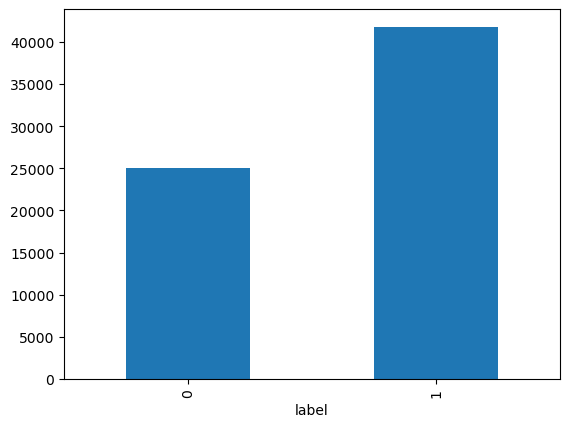

In [4]:
train_df.groupby(['label']).size().plot.bar()

<AxesSubplot:xlabel='label'>

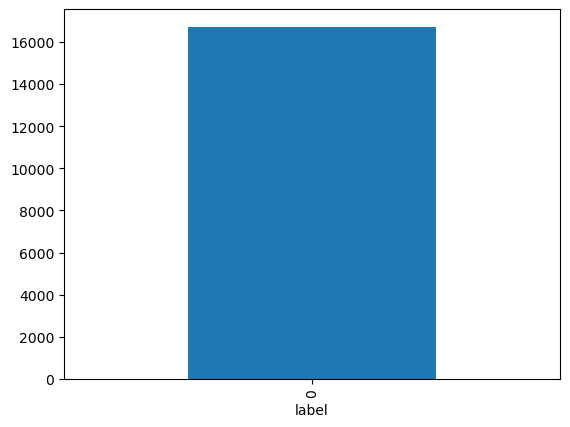

In [5]:
val_df.groupby(['label']).size().plot.bar()

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {"Modern": 0,
          "Shakespeare": 1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['sentence']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [7]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_output = self.softmax(linear_output)

        return final_output

In [8]:
def train(model, train_dataloader, criterion, optimizer, device, batch_size):
    total_acc_train = total_loss_train = total = batch = 0
    
    train = Dataset(train_df)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)    

    for train_input, train_label in tqdm(train_dataloader):
        #print(train_input['input_ids'])
        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)
                
        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()
                
        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc
        total += batch_size

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()
        batch += 1
        if (batch % 500 == 0):
            print(f'Batch: {batch}, Train Loss: {total_loss_train / total: .3f}, Train Accuracy: {total_acc_train / total: .3f}')
    return total_loss_train, total_acc_train
                
def evaluation(model, val_dataloader, criterion, optimizer, device, batch_size):
    total_acc_val = total_loss_val = total = batch = 0
    
    val = Dataset(val_df)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    with torch.no_grad():
        for val_input, val_label in tqdm(val_dataloader):
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()
                    
            acc = (output.argmax(dim=1) == val_label).sum().item()
            total_acc_val += acc
            total += batch_size
            batch += 1
            if (batch % 500 == 0):
                print(f'Batch: {batch}, Val Loss: {total_loss_val / total: .3f}, Val Accuracy: {total_acc_val / total: .3f}')
        return total_loss_val, total_acc_val

In [11]:
def train_and_evaluate(number_of_epochs, model, train_df, val_df, LR, batch_size):
    optimizer = Adam(model.parameters(), lr= LR)
    criterion = nn.CrossEntropyLoss()
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
        
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(number_of_epochs):
        print("Epoch:", epoch+1)
        total_loss_train, total_acc_train = train(model, train_df, criterion, optimizer, device, batch_size)
        with torch.no_grad():
            total_loss_val, total_acc_val = evaluation(model, val_df, criterion, optimizer, device, batch_size)
        print(f'Train Loss: {total_loss_train / len(train_df): .3f}, Train Accuracy: {total_acc_train / len(train_df): .3f}, Val Loss: {total_loss_val / len(val_df): .3f}, Val Accuracy: {total_acc_val / len(val_df): .3f}')
    return

In [12]:
EPOCHS = 5
model = BertClassifier()
LR = 0.005
batch_size = 20

train_and_evaluate(EPOCHS, model, train_df, val_df, LR, batch_size)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1


 15%|█▍        | 500/3345 [08:12<46:38,  1.02it/s]

Batch: 500, Train Loss:  0.048, Train Accuracy:  0.546


 30%|██▉       | 1000/3345 [16:24<38:24,  1.02it/s]

Batch: 1000, Train Loss:  0.047, Train Accuracy:  0.542


 45%|████▍     | 1500/3345 [24:35<30:17,  1.02it/s]

Batch: 1500, Train Loss:  0.047, Train Accuracy:  0.541


 60%|█████▉    | 2000/3345 [32:47<22:01,  1.02it/s]

Batch: 2000, Train Loss:  0.047, Train Accuracy:  0.542


 75%|███████▍  | 2500/3345 [40:59<13:50,  1.02it/s]

Batch: 2500, Train Loss:  0.047, Train Accuracy:  0.545


 90%|████████▉ | 3000/3345 [49:10<05:39,  1.02it/s]

Batch: 3000, Train Loss:  0.047, Train Accuracy:  0.544


 60%|█████▉    | 500/837 [02:48<01:53,  2.98it/s]

Batch: 500, Val Loss:  0.028, Val Accuracy:  0.711


100%|██████████| 837/837 [04:40<00:00,  2.98it/s]


Train Loss:  0.047, Train Accuracy:  0.543, Val Loss:  0.028, Val Accuracy:  0.710
Epoch: 2


 15%|█▍        | 500/3345 [08:11<46:33,  1.02it/s]

Batch: 500, Train Loss:  0.047, Train Accuracy:  0.546


 30%|██▉       | 1000/3345 [16:22<38:22,  1.02it/s]

Batch: 1000, Train Loss:  0.048, Train Accuracy:  0.538


 45%|████▍     | 1500/3345 [24:34<30:13,  1.02it/s]

Batch: 1500, Train Loss:  0.047, Train Accuracy:  0.544


 60%|█████▉    | 2000/3345 [32:46<22:01,  1.02it/s]

Batch: 2000, Train Loss:  0.047, Train Accuracy:  0.544


 75%|███████▍  | 2500/3345 [40:57<13:49,  1.02it/s]

Batch: 2500, Train Loss:  0.047, Train Accuracy:  0.545


 90%|████████▉ | 3000/3345 [49:09<05:38,  1.02it/s]

Batch: 3000, Train Loss:  0.047, Train Accuracy:  0.544


 60%|█████▉    | 500/837 [02:47<01:53,  2.98it/s]

Batch: 500, Val Loss:  0.027, Val Accuracy:  0.717


100%|██████████| 837/837 [04:40<00:00,  2.98it/s]


Train Loss:  0.047, Train Accuracy:  0.545, Val Loss:  0.027, Val Accuracy:  0.718
Epoch: 3


 15%|█▍        | 500/3345 [08:11<46:40,  1.02it/s]

Batch: 500, Train Loss:  0.048, Train Accuracy:  0.545


 30%|██▉       | 1000/3345 [16:22<38:24,  1.02it/s]

Batch: 1000, Train Loss:  0.046, Train Accuracy:  0.547


 45%|████▍     | 1500/3345 [24:34<30:13,  1.02it/s]

Batch: 1500, Train Loss:  0.047, Train Accuracy:  0.545


 60%|█████▉    | 2000/3345 [32:46<22:04,  1.02it/s]

Batch: 2000, Train Loss:  0.048, Train Accuracy:  0.544


 75%|███████▍  | 2500/3345 [40:58<13:50,  1.02it/s]

Batch: 2500, Train Loss:  0.047, Train Accuracy:  0.544


 90%|████████▉ | 3000/3345 [49:10<05:39,  1.02it/s]

Batch: 3000, Train Loss:  0.047, Train Accuracy:  0.542


 60%|█████▉    | 500/837 [02:48<01:53,  2.98it/s]

Batch: 500, Val Loss:  0.041, Val Accuracy:  0.515


100%|██████████| 837/837 [04:40<00:00,  2.98it/s]


Train Loss:  0.047, Train Accuracy:  0.543, Val Loss:  0.042, Val Accuracy:  0.510
Epoch: 4


 15%|█▍        | 500/3345 [08:11<46:55,  1.01it/s]

Batch: 500, Train Loss:  0.048, Train Accuracy:  0.543


 30%|██▉       | 1000/3345 [16:23<38:27,  1.02it/s]

Batch: 1000, Train Loss:  0.047, Train Accuracy:  0.549


 45%|████▍     | 1500/3345 [24:35<30:18,  1.01it/s]

Batch: 1500, Train Loss:  0.047, Train Accuracy:  0.546


 60%|█████▉    | 2000/3345 [32:47<22:03,  1.02it/s]

Batch: 2000, Train Loss:  0.047, Train Accuracy:  0.544


 75%|███████▍  | 2500/3345 [40:59<13:51,  1.02it/s]

Batch: 2500, Train Loss:  0.047, Train Accuracy:  0.544


 90%|████████▉ | 3000/3345 [49:11<05:38,  1.02it/s]

Batch: 3000, Train Loss:  0.047, Train Accuracy:  0.543


 60%|█████▉    | 500/837 [02:47<01:53,  2.97it/s]

Batch: 500, Val Loss:  0.054, Val Accuracy:  0.383


100%|██████████| 837/837 [04:40<00:00,  2.98it/s]


Train Loss:  0.047, Train Accuracy:  0.542, Val Loss:  0.054, Val Accuracy:  0.380
Epoch: 5


 15%|█▍        | 500/3345 [08:11<46:55,  1.01it/s]

Batch: 500, Train Loss:  0.047, Train Accuracy:  0.544


 30%|██▉       | 1000/3345 [16:24<38:31,  1.01it/s]

Batch: 1000, Train Loss:  0.047, Train Accuracy:  0.540


 45%|████▍     | 1500/3345 [24:35<30:17,  1.02it/s]

Batch: 1500, Train Loss:  0.047, Train Accuracy:  0.540


 60%|█████▉    | 2000/3345 [32:47<21:59,  1.02it/s]

Batch: 2000, Train Loss:  0.047, Train Accuracy:  0.540


 75%|███████▍  | 2500/3345 [40:59<13:57,  1.01it/s]

Batch: 2500, Train Loss:  0.047, Train Accuracy:  0.541


 90%|████████▉ | 3000/3345 [49:11<05:39,  1.02it/s]

Batch: 3000, Train Loss:  0.047, Train Accuracy:  0.540


 60%|█████▉    | 500/837 [02:48<01:53,  2.98it/s]

Batch: 500, Val Loss:  0.126, Val Accuracy:  0.035


100%|██████████| 837/837 [04:41<00:00,  2.98it/s]

Train Loss:  0.047, Train Accuracy:  0.542, Val Loss:  0.126, Val Accuracy:  0.035
